In [10]:
import atlite
import geopandas as gpd
import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from matplotlib.gridspec import GridSpec
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from cartopy.crs import PlateCarree as plate
import numpy as np
import matplotlib.patheffects as path_effects
import yaml


# Load Geodata
load you regions to which you want to aggregate the wind speeds from the "input_data" folder

In [2]:
dirname = os.getcwd()
dirname = os.path.join(dirname, '..') #go one folder up to main dir of tool


with open(os.path.join(dirname, "configs/config_template.yaml"), "r", encoding="utf-8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)  

weather_year = config['weather_year']
study_region_name = config['study_region_name']
region_name_clean = study_region_name
data_path = os.path.join(dirname, 'data', region_name_clean)

# # Load the CRS
# # geo CRS
# with open(os.path.join(data_path, region_name_clean+'_global_CRS.pkl'), 'rb') as file:
#         global_crs_obj = pickle.load(file)
# # projected CRS
# with open(os.path.join(data_path, region_name_clean+'_local_CRS.pkl'), 'rb') as file:
#         local_crs_obj = pickle.load(file)
# # Extract tag for filename, e.g., 'EPSG3035' or 'ESRI102003'
# auth = global_crs_obj.to_authority()
# global_crs_tag = ''.join(auth) if auth else global_crs_obj.to_string().replace(":", "_")
# auth = local_crs_obj.to_authority()
# local_crs_tag = ''.join(auth) if auth else local_crs_obj.to_string().replace(":", "_")

regionPath = os.path.join(data_path, f'{region_name_clean}_EPSG4326.geojson')
region = gpd.read_file(regionPath)


# Load and process the cutout

In [3]:
#load cutout 
cutout_name = config['cutout_name'].format(year=weather_year)
print(cutout_name)
cutout = atlite.Cutout(os.path.join(dirname, 'Raw_Spatial_Data', 'weather_data', f"{cutout_name}.nc"))

#get max wind speed over all dimensions
max_wind_speed = float(cutout.data['wnd100m'].max().compute())
print(f'max wind speed: {max_wind_speed}')

#access cutout data
cutout.data

DNK-2019-era5
max wind speed: 27.52643394470215


<xarray.Dataset> Size: 79MB
Dimensions:        (x: 30, y: 15, time: 8760)
Coordinates:
  * x              (x) float64 240B 8.0 8.25 8.5 8.75 ... 14.5 14.75 15.0 15.25
  * y              (y) float64 120B 54.5 54.75 55.0 55.25 ... 57.5 57.75 58.0
  * time           (time) datetime64[ns] 70kB 2019-01-01 ... 2019-12-31T23:00:00
    lon            (x) float64 240B dask.array<chunksize=(30,), meta=np.ndarray>
    lat            (y) float64 120B dask.array<chunksize=(15,), meta=np.ndarray>
Data variables:
    wnd100m        (time, y, x) float32 16MB dask.array<chunksize=(100, 15, 30), meta=np.ndarray>
    wnd_shear_exp  (time, y, x) float64 32MB dask.array<chunksize=(100, 15, 30), meta=np.ndarray>
    wnd_azimuth    (time, y, x) float32 16MB dask.array<chunksize=(100, 15, 30), meta=np.ndarray>
    roughness      (time, y, x) float32 16MB dask.array<chunksize=(100, 15, 30), meta=np.ndarray>
Attributes:
    module:                  era5
    prepared_features:       wind
    chunksize_time:          100
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-25T11:29 GRIB to CDM+CF via cfgrib-0.9.1...

## wind speeds

In [11]:
#interactive plot mean wind speed over whole year for each pixel
wnd100mean = cutout.data.wnd100m.mean(dim="time")

quadmesh_plot = wnd100mean.hvplot.quadmesh(
    "x",
    "y",
    "wnd100m",
    frame_height=500,
    cmap="viridis",
    geo=True,
    tiles="CartoLight",
    alpha=0.8,
    padding=0.5,
    clim=(0, 10),
    title='mean windspeed @100m',
    hover_cols=['x', 'y', 'wnd100m'],  # Include x, y, and wind speed in hover
)

polygon_plot1 = region.hvplot(
    geo=True,
    line_color='black',
    fill_alpha=0,
    line_width=1.5,
)

overlay = quadmesh_plot * polygon_plot1

re_areas_path = os.path.join(dirname, config['shapes_path'])
if os.path.exists(re_areas_path):
    RE_areas = gpd.read_file(re_areas_path)
    name_col = config.get("shapes_name_column", "name")
    RE_areas = RE_areas.set_index(name_col).rename_axis("region")
    polygon_plot2 = RE_areas.hvplot(
        geo=True,
        line_color='red',
        fill_alpha=0,
        line_width=1.5,
    )
    overlay = overlay * polygon_plot2

# Display the final overlay plot
overlay


:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .QuadMesh.I  :QuadMesh   [x,y]   (wnd100m,x,y,wnd100m)
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

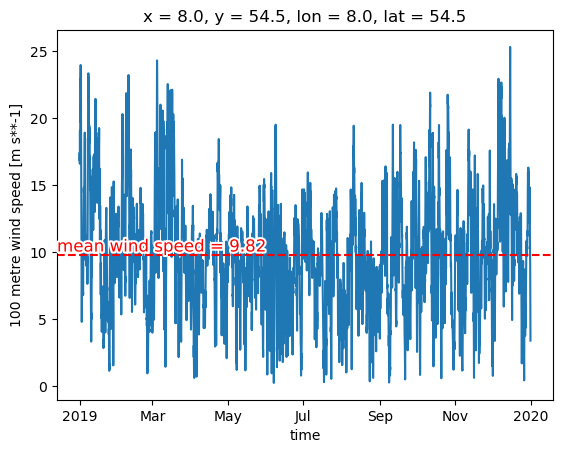

In [12]:
#access the wind speed data of a certain pixel (pixel index)
x=0
y=0
wind_pixel = cutout.data['wnd100m'].isel(x=x, y=y)
# Plot the wind speed over time
wind_pixel.plot.line()
#add mean wind speed
mean_wind_speed_pixel = cutout.data.wnd100m.mean(dim="time").isel(x=x, y=y).values
plt.axhline(y=mean_wind_speed_pixel, color='r', linestyle='--', label=f'mean wind speed')
text = plt.text(x=plt.xlim()[0], y=mean_wind_speed_pixel, s=f'mean wind speed = {mean_wind_speed_pixel:.2f}', 
         color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

# Add stroke effect (white outline)
text.set_path_effects([
    path_effects.withStroke(linewidth=3, foreground="white")
])

## cutout and aggregated wind speed over whole country

In [13]:
#standards for all plots
# Compute centroid of the region (in EPSG:4326) for centering the projection
region_4326 = region.to_crs(epsg=4326)
centroid = region_4326.geometry.unary_union.centroid
projection = ccrs.Mollweide(central_longitude=centroid.x)

# Bounding box for zoom (with a small buffer)
x1, y1, x2, y2 = region_4326.total_bounds
buf = 2  # degrees buffer
extent = [x1 - buf, x2 + buf, y1 - buf, y2 + buf]  # [lon_min, lon_max, lat_min, lat_max]

cells = cutout.grid
cutout_bound = gpd.GeoSeries(cells.unary_union)


C:\Users\b396636\AppData\Local\Temp\ipykernel_27384\3359944669.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = region_4326.geometry.unary_union.centroid
C:\Users\b396636\AppData\Local\Temp\ipykernel_27384\3359944669.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cutout_bound = gpd.GeoSeries(cells.unary_union)


Text(0.5, 1.0, 'mean windspeed over the whole country')

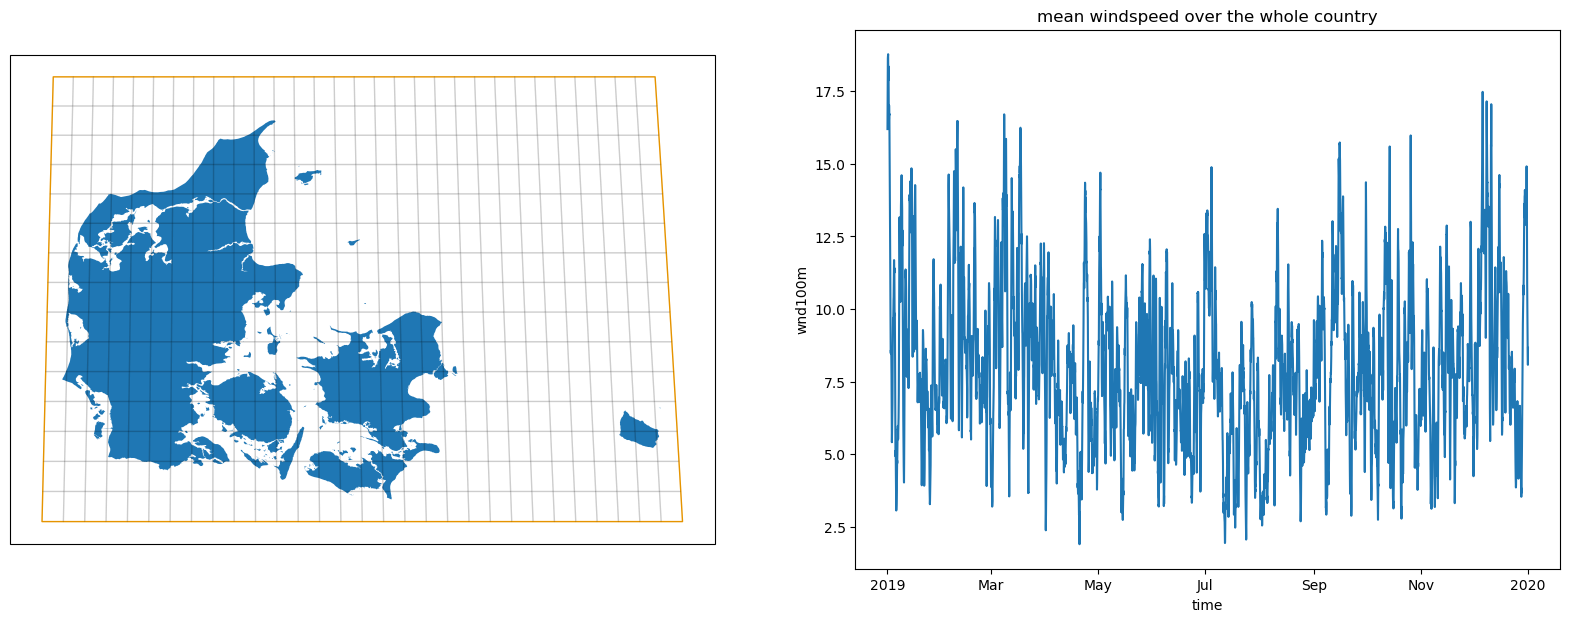

In [14]:
#plot country and mean windspeed over whole country for overview
#cartopy approach --> projections and transformation
fig = plt.figure(figsize=(20, 7))
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
region.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
cutout_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 1])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_title('mean windspeed over the whole country')
#ax1.set_frame_on(False)
#ax1.xaxis.set_visible(False)

# aggregate wind speed timeseries per model area

In [15]:
#check data structure of wind turbine to define helper turbine
atlite.resource.get_windturbineconfig('NREL_ReferenceTurbine_5MW_offshore')

c:\Users\b396636\AppData\Local\anaconda3\envs\atlite\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


{'V': array([ 0,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 25, 25]),
 'POW': array([0.    , 0.    , 0.0405, 0.1777, 0.4039, 0.7376, 1.1872, 1.7711,
        2.5186, 3.4484, 4.5625, 5.    , 5.    , 0.    ]),
 'hub_height': 90.0,
 'P': 5.0}

In [16]:
#create helper power curve where wind speeds are mapped to themselves 
# the nameplate capacity of this helper_turbine is the max_wind_speed to have values normalized to this wind speed later 
# get like a hourly CF timeseries where 1 equals to the max_wind_speed 
wind_speed = np.arange(0, 31, 1)

helper_turbine = {'V':wind_speed, 'POW':wind_speed, 'hub_height':100, 'P':max_wind_speed}

#check helper turbine
atlite.resource.get_windturbineconfig(helper_turbine)

The power curve does not have a cut-out wind speed, i.e. the power output corresponding to the
highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.


{'V': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'POW': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 'hub_height': 100,
 'P': 27.52643394470215}

In [17]:
#do the aggregation
windspeed_aggregated_areas = cutout.wind(
    helper_turbine, 
    per_unit=True, 
    shapes=RE_areas) #, layout=layout) #Vestas_V112_3MW #capacity_factor=True

windspeed_aggregated_areas = windspeed_aggregated_areas * max_wind_speed
results = windspeed_aggregated_areas.to_pandas()
results

The power curve does not have a cut-out wind speed, i.e. the power output corresponding to the
highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.


region,West,East
time,,
2019-01-01 00:00:00,17.767328,13.767012
2019-01-01 01:00:00,18.382785,14.347978
2019-01-01 02:00:00,19.109819,15.180565
2019-01-01 03:00:00,19.018387,15.764084
2019-01-01 04:00:00,20.567319,16.497362
...,...,...
2019-12-31 19:00:00,8.977135,8.348245
2019-12-31 20:00:00,8.141505,8.051899
2019-12-31 21:00:00,8.182899,7.954447


# Inspect the results 

Text(429528.0, 9.0683264833543, 'mean wind speed = 9.07')

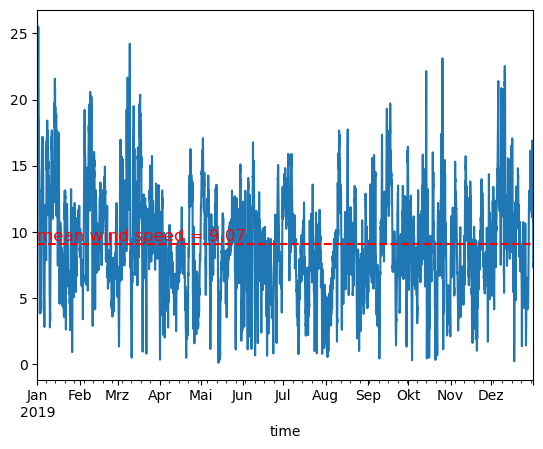

In [18]:
#plot selected region
area = 'West'
results[area].plot()
#add mean wind speed
mean_wind_speed_area = results[area].mean()
plt.axhline(y=mean_wind_speed_area, color='r', linestyle='--', label=f'mean wind speed')
plt.text(x=plt.xlim()[0], y=mean_wind_speed_area, s=f'mean wind speed = {mean_wind_speed_area:.2f}', 
         color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

In [19]:
#get max wind speeds after aggregation 
print('overall total: ', results.max().max())

results.max()

overall total:  25.49967372271635


region
West    25.499674
East    19.912517
dtype: float64

In [20]:
results.mean()

region
West    9.068326
East    7.592800
dtype: float64

# cap factor

In [21]:
cap_factors = cutout.wind(turbine=atlite.resource.get_oedb_windturbineconfig(name='E-53/800'), per_unit=True, shapes=RE_areas) #nrea_lands_model_areas
cf_wind_df = cap_factors.to_pandas()
cf_wind_df.mean()

Multiple values for hub_height in dataset ([50.0, 60.0, 73.0]). Manual clean-up required. Using the averge 61m for now.
c:\Users\b396636\AppData\Local\anaconda3\envs\atlite\Lib\site-packages\atlite\resource.py:90: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)
The power curve does not have a cut-out wind speed, i.e. the power output corresponding to the
highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.


region
West    0.500413
East    0.349796
dtype: float64

# Solar

## no tracking

In [ ]:
cf_pv_0axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking=None,
    per_unit=True,
)

round(cf_pv_0axis.to_pandas().mean().mean(), 3)

## 1-axis horizontal tracking

In [ ]:
cf_pv_1axis_h = cutout.pv(
    panel="CSi",
    orientation={"slope": 0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking="horizontal",
    per_unit=True,
)

round(cf_pv_1axis_h.to_pandas().mean().mean(), 3)

## comparison of time series

In [ ]:
cells = cutout.grid
point = cells[(cells["y"] == 25) & (cells["x"] == 25)].index
day = "2019-05-01"

data = [cf_pv_1axis_h, cf_pv_0axis]
labels = [
    "1-axis horizontal tracking",
    "No tracking",
]

## Day profile

In [ ]:
day_profiles = [ds.loc[day, point].squeeze() for ds in data]

df = pd.DataFrame({k: v.to_series() for k, v in zip(labels, day_profiles)})
df.plot(figsize=(10, 5))